# In-host dynamics of SARS-CoV-2
Based on two articles: 
* Within Host Dynamics of SARS‑CoV‑2 in Humans: Modeling Immune
Responses and Antiviral Treatments;
Indrajit Ghosh
* Modelling of the Innate and Adaptive Immune Response to
SARS Viral Infection, Cytokine Storm and Vaccination;
Cristina Leon, Alexey Tokarev, Anass Bouchnita and Vitaly Volpert

1. Start from simple **compatmental model** of virus-host cell dynamics
    - H(t)=healthy uninfected cells
    - V(t)=free virus
    - I(t)=infected cells

Infected cells I produce virus particles V that leave the cell and find other susceptible target cells H.



In [33]:
# imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


A virus-clearance event was implemented uniformly across all models by terminating numerical integration when the viral load dropped below a fixed threshold.

Numerical integration was terminated once the viral load dropped below a clearance threshold 
V<10^−6
, reflecting effective elimination of the virus and preventing unnecessary computation in the post-clearance regime.

The viral load is negligible compared to biologically relevant levels.
* Below detection limit
* Immune clearance achieved
* No further biological impact

Although viral particles and cells are discrete entities, the model describes average concentrations and is formulated as a deterministic ODE system. Consequently, viral clearance is defined operationally by a small threshold value rather than an exact zero, corresponding to a viral load below biologically relevant or detectable levels. To have proper extinction we should have a stochastic model

In [34]:
t_span = (0, 30)
t_eval = np.linspace(0, 30, 1500)

def compute_virus_clearance(
    t,
    V,
    V_clear=10.0,
    min_duration=0.5
):
    """
    Determine whether viral clearance occurs and estimate clearance time.

    Parameters
    ----------
    t : array_like
        Time points (days), monotonically increasing.
    V : array_like
        Viral load trajectory (same length as t).
    V_clear : float, optional
        Clearance threshold (default: 1.0).
    min_duration : float, optional
        Minimum time (days) V must stay below threshold
        to be considered true clearance.

    Returns
    -------
    cleared : bool
        True if clearance occurs.
    t_clear : float or None
        Estimated clearance time (days), None if no clearance.
    """

    t = np.asarray(t)
    V = np.asarray(V)

    # Indices where virus is below threshold
    below = V < V_clear

    if not np.any(below):
        return False, None

    # Find first index where V goes below threshold
    idx_start = np.where(below)[0][0]

    # Check how long it stays below
    t_start = t[idx_start]
    duration = t[-1] - t_start

    if duration < min_duration:
        return False, None

    # Ensure it does not rebound above threshold
    if np.any(V[idx_start:] >= V_clear):
        return False, None

    return True, t_start


Cleared: False
Clearance time: None


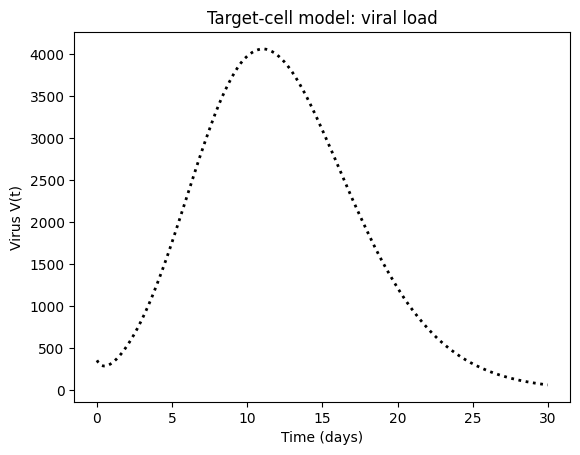

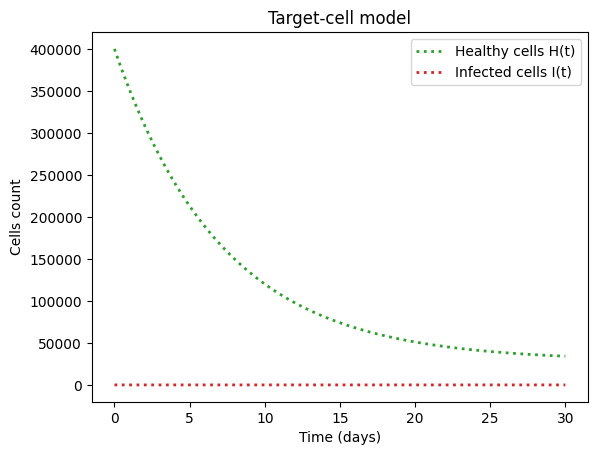

In [35]:
# simple compartmental model
def target_cell_model(t, y, params):
    H, I, V = y 
    Pi, beta, mu1, mu2, mu3, k1 = params

    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - mu2 * I
    dVdt = k1 * I - mu3 * V

    return [dHdt, dIdt, dVdt]

params_tc = [
    4e3,        # Π (cells ml⁻¹ day⁻¹)
    2e-8,  # beta  (ml RNA⁻¹ day⁻¹, mid-range)
    0.14,       # μ1 (day⁻¹)
    0.65,       # μ2 (day⁻¹)
    0.9004,     # mu3  
    253.5       # k1  (virions cell⁻¹ day⁻¹)
]

y0_tc = [4e5, 3e-4, 357] 

sol_tc = solve_ivp(
    target_cell_model, t_span, y0_tc,
    args=(params_tc,), t_eval=t_eval, 
)

cleared_tc, t_clear_tc = compute_virus_clearance(
    sol_tc.t, sol_tc.y[2],
    min_duration=0.5
)
print("Cleared:", cleared_tc)
print("Clearance time:", t_clear_tc)

plt.plot(sol_tc.t, sol_tc.y[2], color="#000000", ls=":", lw=2.0)
if t_clear_tc is not None:
    plt.axvline(
        t_clear_tc,
        color="black",
        linestyle=":",
        linewidth=2,
        alpha=0.7,
        label="Virus clearance"
    )
    plt.text(
    t_clear_tc + 0.2,
    plt.ylim()[1] * 0.6,
    f"t = {t_clear_tc:.1f} d",
    rotation=90,
    va="center",
    fontsize=10
)

plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.title("Target-cell model: viral load")
plt.show()

plt.plot(sol_tc.t, sol_tc.y[0], label="Healthy cells H(t)", color="#2ca02c", ls=":", lw=2.0)
plt.plot(sol_tc.t, sol_tc.y[1], label="Infected cells I(t)", color="#d62728", ls=":", lw=2.0)
plt.xlabel("Time (days)")
plt.ylabel("Cells count")
plt.title("Target-cell model")
plt.legend()
plt.show()


In [36]:
Rw=params_tc[0]*params_tc[1]*params_tc[5]/(params_tc[3]*params_tc[4]*params_tc[2])
print(Rw)

0.24750904359967


In [37]:
import sympy as sp

# Define symbols
H, I, V = sp.symbols('H I V', nonnegative=True)
Pi, beta, mu1, mu2, mu3, k1 = sp.symbols(
    'Pi beta mu1 mu2 mu3 k1', positive=True
)

# Define equations
eqs = [
    Pi - beta*H*V - mu1*H,
    beta*H*V - mu2*I,
    k1*I - mu3*V
]

# Solve
equilibria = sp.solve(eqs, (H, I, V), dict=True)

equilibria


[{H: Pi/mu1, I: 0, V: 0},
 {H: mu2*mu3/(beta*k1),
  I: (Pi*beta*k1 - mu1*mu2*mu3)/(beta*k1*mu2),
  V: (Pi*beta*k1 - mu1*mu2*mu3)/(beta*mu2*mu3)}]

Epidemic threshold (within-host): $$\Pi\beta k_1-\mu_1\mu_2\mu_3>0$$ -> $$R_w=\frac{\Pi\beta k_1}{\mu_1\mu_2\mu_3}>1$$

2. Add innate immune response

Innate immune response works non-specifically and immediately. 
Cytokines C(t) inhibit viral replication. Specific cytokines activate Netural Killer cells N(t), which kill virus-infected cells.


Cleared: False
Clearance time: None


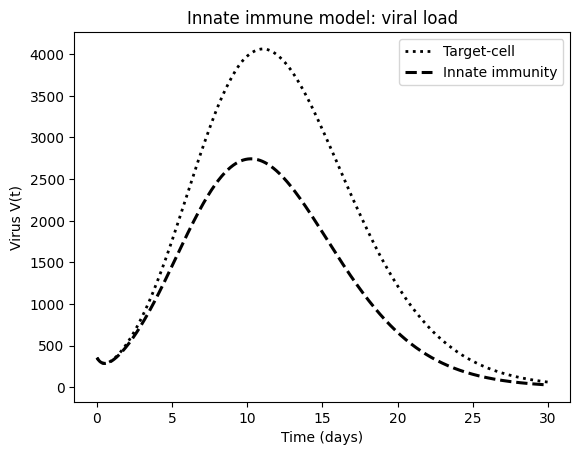

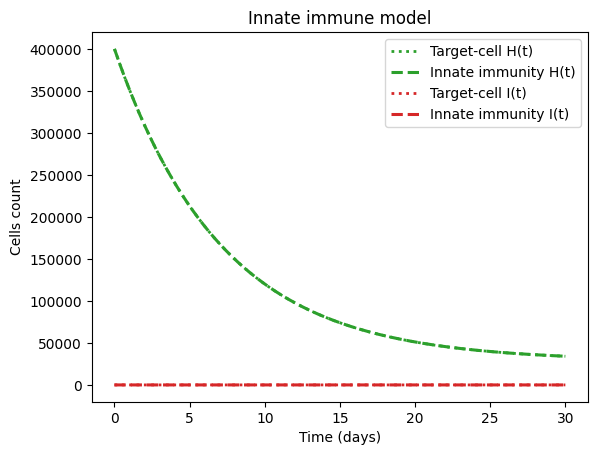

In [38]:
def innate_model(t, y, params):
    H, I, V, C, N = y
    Pi, beta, gamma, mu1, mu2, mu3, mu4, mu5, k1, k2, p2, p5, r = params

    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - p5 * N * I - mu2 * I
    dVdt = k1 * I - p2 * C * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N

    return [dHdt, dIdt, dVdt, dCdt, dNdt]

params_innate = [
    4e3,        # Π (production rate of healthy cells)
    2e-8,       # β (rate healthy cells convert into infected cells)
    0.5,        # gamma (strength of immunosuppression)
    0.14,       # μ1 (death rate healthy cells)
    0.65,       # μ2 (death rate infected cells)
    0.9004,     # μ3 (clearance rate virus)
    0.7,        # μ4 (death rate cytokine)
    0.07,       # μ5 (death rate NK)
    253.5,      # k1 (production rate virus from infected cells)
    5.0,        # k2 (production rate of cytokines)
    0.6104,     # p2 (rate virus neutralized by cytokines)
    5.74e-4,    # p5 (rate infected cells killed by NK)
    0.52        # r (activation rate cytokines)
]

y0_innate = [4e5, 3e-4, 357, 0.0, 100.0]

sol_innate = solve_ivp(
    innate_model, t_span, y0_innate,
    args=(params_innate,), t_eval=t_eval,
    rtol=1e-5, atol=1e-8,
)

cleared_innate, t_clear_innate = compute_virus_clearance(
    sol_innate.t, sol_innate.y[2],
    min_duration=0.5
)
print("Cleared:", cleared_innate)
print("Clearance time:", t_clear_innate)


plt.plot(sol_tc.t, sol_tc.y[2], ls=":", lw=2.0, color="#000000", label="Target-cell")
plt.plot(sol_innate.t, sol_innate.y[2], ls="--", lw=2.2, color="#000000", label="Innate immunity")
if t_clear_innate is not None:
    plt.axvline(
        t_clear_innate,
        color="black",
        linestyle=":",
        linewidth=2,
        alpha=0.7,
        label="Virus clearance"
    )
    plt.text(
    t_clear_innate + 0.2,
    plt.ylim()[1] * 0.6,
    f"t = {t_clear_innate:.1f} d",
    rotation=90,
    va="center",
    fontsize=10
)
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.title("Innate immune model: viral load")
plt.show()

plt.plot(sol_tc.t, sol_tc.y[0], ls=":", lw=2.0, color="#2ca02c", label="Target-cell H(t)")
plt.plot(sol_innate.t, sol_innate.y[0], ls="--", lw=2.2, color="#2ca02c", label="Innate immunity H(t)")
plt.plot(sol_tc.t, sol_tc.y[1], ls=":", lw=2.0, color="#d62728", label="Target-cell I(t)")
plt.plot(sol_innate.t, sol_innate.y[1], ls="--", lw=2.2, color="#d62728", label="Innate immunity I(t)")
plt.xlabel("Time (days)")
plt.ylabel("Cells count")
plt.title("Innate immune model")
plt.legend()
plt.show()


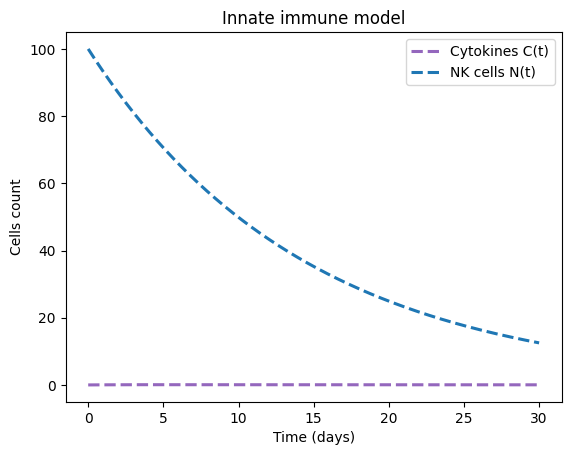

In [39]:
plt.plot(sol_innate.t, sol_innate.y[3], ls="--", lw=2.2, color="#9467bd", label="Cytokines C(t)")
plt.plot(sol_innate.t, sol_innate.y[4], ls="--", lw=2.2, color="#1f77b4", label="NK cells N(t)")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Cells count")
plt.title("Innate immune model")
plt.show()


In [40]:
Rw=params_innate[0]*params_innate[1]*params_innate[8]/(params_innate[3]*params_innate[4]*params_innate[5])
print(Rw)

0.24750904359967


3. Add adaptive immune response

Cytokines also activate the adaptive immune respponse, mainly T-lymphocytes T(t), which find virus infected cells and kill them. T-cells subsequently activate B-lympocytes B(t) to produce antibody A(t) against virus with the
aim of halting infection (and in future providing protection against a subsequent infection).


Cleared: True
Clearance time: 12.928619079386257


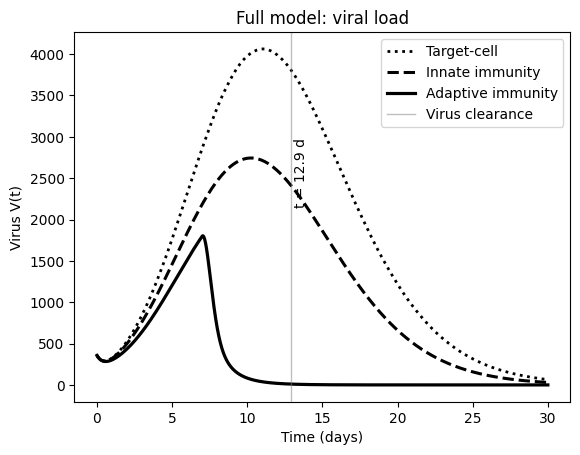

In [41]:
def full_model(t, y, params):
    H, I, V, C, N, T, B, A = y
    (Pi, beta, gamma, 
    mu1, mu2, mu3, mu4, mu5, mu6, mu7, mu8, 
    k1, k2, p1, p2, p3, p4, p5, 
    r, lambda1, lambda2, eta, tau ) = params

    G = 1.0 if t >= tau else 0.0   # antibody delay
    
    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - p5 * N * I - p1 * T * I - mu2 * I
    dVdt = k1 * I - p2 * C * V - p3 * A * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N
    dTdt = lambda1 * C * T - mu6 * T
    dBdt = lambda2 * T * B - mu7 * B
    dAdt = G * eta * B - mu8 * A - p4 * A * V

    return [dHdt, dIdt, dVdt, dCdt, dNdt, dTdt, dBdt, dAdt]

params_full = [
    4e3,        # Pi
    2e-8,       # beta  
    0.5,        # gamma
    0.14,       # mu1
    0.65,       # mu2  
    0.9004,     # mu3  
    0.7,        # mu4
    0.07,       # mu5
    1.0,        # mu6
    0.2,        # mu7
    0.07,       # mu8
    253.5,      # k1   
    5.0,        # k2   
    0.001,      # p1
    0.6104,     # p2   
    0.01865,       # p3   
    3e-7,       # p4   
    5.74e-4,    # p5
    0.52,       # r
    0.1,        # lambda1
    0.01,       # lambda2
    0.05,       # eta 
    7.0         # tau 
]


y0_immune = [
    4e5,  # H
    3e-4,  # I
    357, # V
    0.0,  # C
    100,  # N
    500,  # T
    100,  # B
    0.0   # A, no antibodies initially
]


sol_immune = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_full,), t_eval=t_eval, method="BDF",
    rtol=1e-6,
    atol=1e-9,
)

cleared_immune, t_clear_immune = compute_virus_clearance(
    sol_immune.t, sol_immune.y[2],
    min_duration=0.5
)
print("Cleared:", cleared_immune)
print("Clearance time:", t_clear_immune)


plt.plot(sol_tc.t, sol_tc.y[2], ls=":", lw=2.0, color="#000000", label="Target-cell")
plt.plot(sol_innate.t, sol_innate.y[2], ls="--", lw=2.2, color="#000000", label="Innate immunity")
plt.plot(sol_immune.t, sol_immune.y[2], ls="-", lw=2.3, color="#000000", label="Adaptive immunity")
if t_clear_immune is not None:
    plt.axvline(
        t_clear_immune,
        color="grey",
        linestyle="-",
        linewidth=1,
        alpha=0.5,
        label="Virus clearance"
    )
    plt.text(
        t_clear_immune + 0.2,
        plt.ylim()[1] * 0.6,
        f"t = {t_clear_immune:.1f} d",
        rotation=90,
        va="center",
        fontsize=10
    )
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.title("Full model: viral load")
plt.legend()
plt.show()


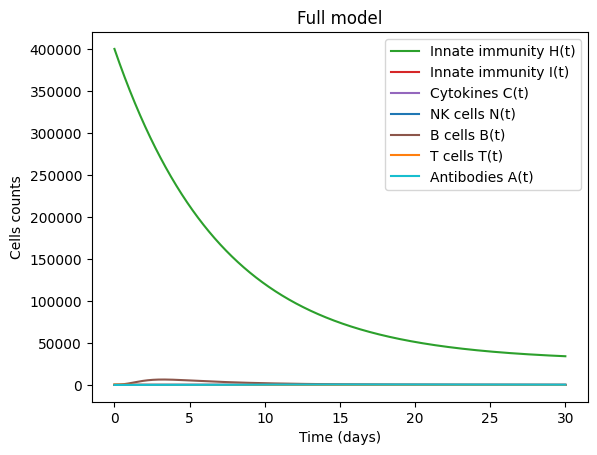

In [42]:
plt.plot(sol_immune.t, sol_immune.y[0], color="#2ca02c", label="Innate immunity H(t)")
plt.plot(sol_immune.t, sol_immune.y[1], color="#d62728", label="Innate immunity I(t)")
plt.plot(sol_immune.t, sol_immune.y[3],  color="#9467bd", label="Cytokines C(t)")
plt.plot(sol_immune.t, sol_immune.y[4],  color="#1f77b4", label="NK cells N(t)")
plt.plot(sol_immune.t, sol_immune.y[-2], color="#8c564b", label="B cells B(t)")
plt.plot(sol_immune.t, sol_immune.y[-3], color="#ff7f0e", label="T cells T(t)")
plt.plot(sol_immune.t, sol_immune.y[-1], color="#17becf", label="Antibodies A(t)")
plt.xlabel("Time (days)")
plt.ylabel("Cells counts")
plt.title("Full model")
plt.legend()
plt.show()



In [43]:
Rw=params_full[0]*params_full[1]*params_full[11]/(params_full[3]*params_full[4]*params_full[5])
print(Rw)

0.24750904359967


This model has four equilibria, as identified in the original study.

- Disease-Free Equilibrium (DFE)

    The disease-free equilibrium corresponds to complete viral clearance and absence of immune activation:
    E_0=(1/μ_1 Π,0,0,0,0,0,0,0).

    This equilibrium is locally asymptotically stable when the basic reproduction number R0<1

- Virus Persistence Equilibrium Without Immune Responses

    In the absence of innate and adaptive immune responses, a virus-persistence equilibrium exists:

    E1=(H1,I1,V1,0,0,0,0,0),

    where

    𝐻1=Π/(𝜇1𝑅0), 𝐼1=𝜇1𝜇3/(𝛽𝑘1) (𝑅0−1), 𝑉1=𝜇1/𝛽 (𝑅w−1)
    and     𝑅w=Π𝛽𝑘1/(𝜇1𝜇2𝜇3)

    This equilibrium exists only for 
    𝑅w>1

- Virus Persistence Equilibrium Without Adaptive Immunity

    When innate immune responses are present but adaptive immunity is absent, the system admits the equilibrium:

    𝐸2=(𝐻2,𝐼2,𝑉2,𝐶2,𝑁2,0,0,0)

    where, denoting 
    𝑄=𝛽𝐻2𝑉2,

    𝐻2=(Π−𝑄)/𝜇1, 𝐼2=𝑄/(𝜇2+𝑝5𝑁2), 𝑁2=𝑟𝐶2/𝜇5,
    𝑉2=1/𝛾 (𝑘2𝐼2/(𝜇4𝐶2)−1)

    The cytokine concentration C2 is determined as the unique positive root of a cubic polynomial arising from the steady-state conditions. This equilibrium exists when the innate immune response is sufficiently strong to sustain immune activation but insufficient to clear the virus.

- Full Virus–Immune Coexistence Equilibrium

    When both innate and adaptive immune responses are active, the system admits the coexistence equilibrium:

    𝐸3=(𝐻3,𝐼3,𝑉3,𝐶3,𝑁3,𝑇3,𝐵3,𝐴3)

    where, letting 
    𝑄=𝛽𝐻3𝑉3, 
    𝐻3=(Π−𝑄)/𝜇1, 𝐼3=𝜇4𝜇6𝑅1/(𝜆1𝑘2), 𝑉3=1/𝛾 (𝑅1−1),
    𝐶3=𝜇6/𝜆1, 𝑁3=𝑟𝐶3/𝜇5, 𝑇3=𝜇7/𝜆2,
    𝐵3=𝐴3/(𝜂(𝑝4𝑉3+𝜇8)),𝐴3=1/𝑝3𝑉3 (𝑅2−1)

    This equilibrium exists only when the immune-related reproduction numbers 
    𝑅1>1 and 
    𝑅2>1

Since the primary interest of this study lies in understanding the outbreak and persistence of infection, we focus on the stability of the disease-free equilibrium. In particular, we investigate the threshold behavior of the system by numerically evaluating the long-term viral load 
V(∞) as a function of the basic reproduction number Rw. This analysis allows us to characterize the forward bifurcation at Rw=1 and to assess how parameter variations influence viral persistence.
We denote by Rw the within-host reproduction ratio, which governs the stability of the disease-free equilibrium of the intra-host model. This quantity should not be confused with the epidemiological basic reproduction number R0, which we introduce later to describe between-host transmission.

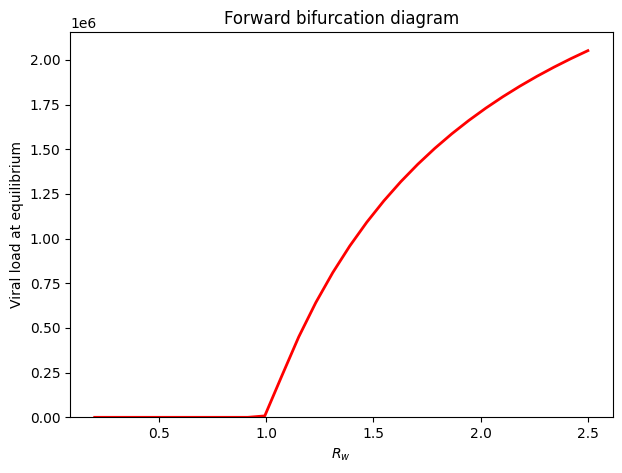

In [44]:
Pi  = 4e3
mu1 = 0.14
mu2 = 0.65
mu3 = 0.9
k1  = 500.0
y0 = [4e5, 3e-4, 357]
Rw_vals = np.linspace(0.2, 2.5, 30)
V_eq = []

for Rw in Rw_vals:
    beta = Rw * mu1 * mu2 * mu3 / (Pi * k1)
    
    params = [Pi, beta, mu1, mu2, mu3, k1]

    sol = solve_ivp(
        target_cell_model,
        (0, 500),              # very long integration
        y0,
        args=(params,),
        t_eval=[500],          # only final value
        rtol=1e-8,
        atol=1e-10
    )

    V_eq.append(sol.y[2, -1])

plt.figure(figsize=(7, 5))
plt.plot(Rw_vals, V_eq, color="red", lw=2)
plt.xlabel(r"$R_w$")
plt.ylabel("Viral load at equilibrium")
plt.title("Forward bifurcation diagram")
plt.ylim(bottom=0)

plt.show()


4. Add vaccination

A vaccine is a biological preparation that provides active acquired immunity to a particular
infectious agent. Thus if an individual is vaccinated, there
will be no delay in the development of antibody. For simplicity, assume that the person is vaccinated a sufficiently
large time ago so that the body develops antibodies against
SARS-CoV-2. Further, let me assume that the person is fully
vaccinated as most of the vaccines come with two doses.
Therefore, the delay term $\tau$ is taken to be zero for vaccinated individuals (see Fig. 7). It is observed that vaccination
not only reduces the viral load in healthy patients but also
reduces the duration of high viremia.

In [45]:
t_span = (0, 20)
t_eval = np.linspace(0, 20, 1500)
from matplotlib.ticker import MaxNLocator


Cleared: True
Clearance time: 3.8425617078052032


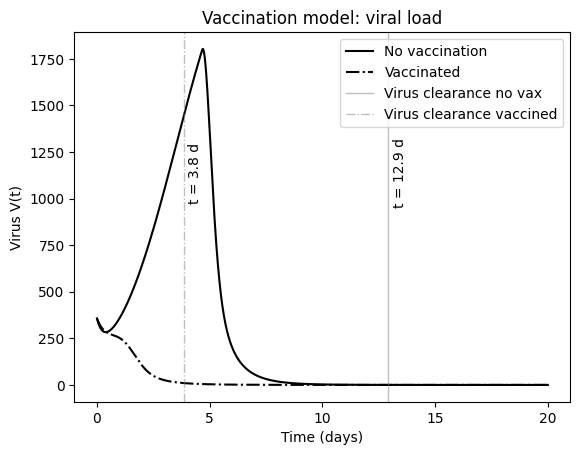

In [46]:

params_vaccine = params_full.copy()
params_vaccine[-1] = 0.0   # delete delay


sol_vaccine = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_vaccine,), t_eval=t_eval,
)

cleared_vaccine, t_clear_vaccine = compute_virus_clearance(
    sol_vaccine.t, sol_vaccine.y[2],
    min_duration=0.5
)
print("Cleared:", cleared_vaccine)
print("Clearance time:", t_clear_vaccine)


plt.plot(sol_vaccine.t, sol_immune.y[2], color="#000000", ls="-", label="No vaccination")
plt.plot(sol_vaccine.t, sol_vaccine.y[2], color="#000000", ls="-.", label="Vaccinated")
if t_clear_immune is not None:
    plt.axvline(
        t_clear_immune,
        color="grey",
        linestyle="-",
        linewidth=1,
        alpha=0.5,
        label="Virus clearance no vax"
    )
    plt.text(
        t_clear_immune + 0.2,
        plt.ylim()[1] * 0.6,
        f"t = {t_clear_immune:.1f} d",
        rotation=90,
        va="center",
        fontsize=10
    )

if t_clear_vaccine is not None:
    plt.axvline(
        t_clear_vaccine,
        color="grey",
        linestyle="-.",
        linewidth=1,
        alpha=0.5,
        label="Virus clearance vaccined"
    )
    plt.text(
        t_clear_vaccine + 0.2,
        plt.ylim()[1] * 0.6,
        f"t = {t_clear_vaccine:.1f} d",
        rotation=90,
        va="center",
        fontsize=10
    )
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.title("Vaccination model: viral load")
plt.legend()
plt.xticks(np.arange(0, 21, 5))
plt.show()


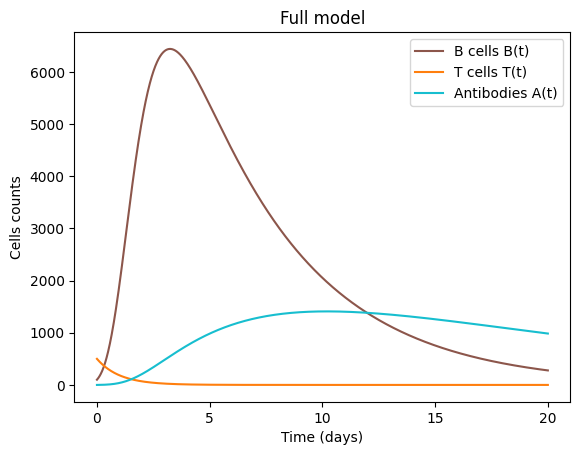

In [47]:
plt.plot(sol_vaccine.t, sol_vaccine.y[-2], color="#8c564b", label="B cells B(t)")
plt.plot(sol_vaccine.t, sol_vaccine.y[-3], color="#ff7f0e", label="T cells T(t)")
plt.plot(sol_vaccine.t, sol_vaccine.y[-1], color="#17becf", label="Antibodies A(t)")
plt.xlabel("Time (days)")
plt.ylabel("Cells counts")
plt.title("Full model")
plt.legend()
plt.xticks(np.arange(0, 21, 5))
plt.show()



Cleared: True
Clearance time: 1.7878585723815876


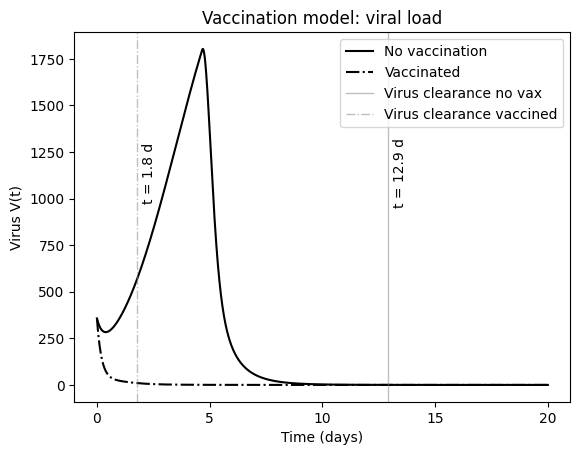

In [48]:
##version 2: already antibody present
params_vaccine = params_full.copy()
params_vaccine[-1] = 0.0   # delete delay

y0_vaccine = [
    4e5,    # H
    3e-4,   # I
    357,    # V
    0.0,    # C
    100,    # N
    500,    # T
    100,    # B
    200.0   # A  <-- key change
]

sol_vaccine2 = solve_ivp(
    full_model, t_span, y0_vaccine,
    args=(params_vaccine,), t_eval=t_eval,
)

cleared_vaccine2, t_clear_vaccine2 = compute_virus_clearance(
    sol_vaccine2.t, sol_vaccine2.y[2],
    min_duration=0.5
)
print("Cleared:", cleared_vaccine2)
print("Clearance time:", t_clear_vaccine2)



plt.plot(sol_vaccine.t, sol_immune.y[2], color="#000000", ls="-", label="No vaccination")
plt.plot(sol_vaccine2.t, sol_vaccine2.y[2], color="#000000", ls="-.", label="Vaccinated")
if t_clear_immune is not None:
    plt.axvline(
        t_clear_immune,
        color="grey",
        linestyle="-",
        linewidth=1,
        alpha=0.5,
        label="Virus clearance no vax"
    )
    plt.text(
        t_clear_immune + 0.2,
        plt.ylim()[1] * 0.6,
        f"t = {t_clear_immune:.1f} d",
        rotation=90,
        va="center",
        fontsize=10
    )

if t_clear_vaccine2 is not None:
    plt.axvline(
        t_clear_vaccine2,
        color="grey",
        linestyle="-.",
        linewidth=1,
        alpha=0.5,
        label="Virus clearance vaccined"
    )
    plt.text(
        t_clear_vaccine2 + 0.2,
        plt.ylim()[1] * 0.6,
        f"t = {t_clear_vaccine2:.1f} d",
        rotation=90,
        va="center",
        fontsize=10
    )
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.title("Vaccination model: viral load")
plt.legend()
plt.xticks(np.arange(0, 21, 5))
plt.show()


5. Add antiviral drug treatment

Antiviral drugs can be used to slow SARS-CoV-2 infection or block production of virus particles. These drugs will necessarily save the lives of many severely ill patients and will reduce the time spent in intensive care units for patients, vacating hospital beds. Antiviral medications will, in turn, inhibit subsequent transmission that could happen if the drugs were not given. To analyze the effect of antiviral treatment, we consider drugs can block infection and/or production of virus particles. Many studies have suggested various existing compounds for testing as SARS-CoV-2 antiviral drug (tocilizumab, Sotrovimab, Bamlanivimab and Etesevimab, Casirivimab and Imdevimab, which have shown significant efficacy and are approved for emergency uses by US Food and Drug Administration). 
Following Zitzmann et al. [50], we incorporate antiviral drug treatment in the proposed model. The effect of antiviral drugs can be either block infection ($\epsilon1$) or block production of viral particles ($\epsilon2$). 
The newly infected term $\beta$ HV now takes the form (1 − $\epsilon1$) $\beta$ HV and the production of viral particles k1I becomes (1 − $\epsilon2$)k1I. Thus, the modified system with antiviral treatment is given by equations.

--- No drug ---
Cleared: True
Clearance time: 16.517678452301535
--- Block infection (ε1=0.5) ---
Cleared: True
Clearance time: 11.887925283522348
--- Block production (ε2=0.5) ---
Cleared: True
Clearance time: 11.754503002001334
--- Combined (ε1=ε2=0.5) ---
Cleared: True
Clearance time: 9.23282188125417


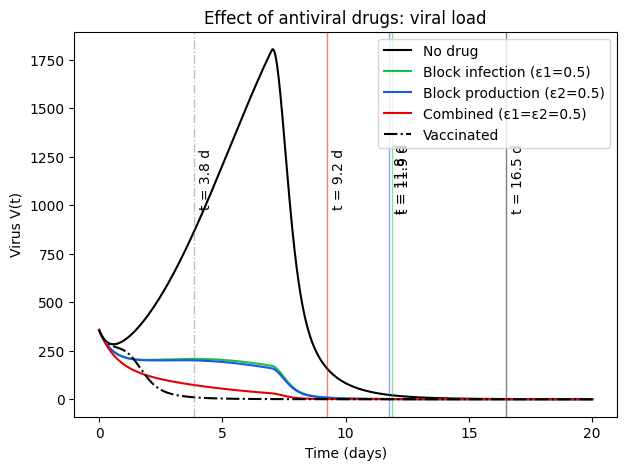

In [49]:
def full_model_drug(t, y, params):
    H, I, V, C, N, T, B, A = y
    (Pi, beta, gamma,
     mu1, mu2, mu3, mu4, mu5, mu6, mu7, mu8,
     k1, k2, p1, p2, p3, p4, p5,
     r, lambda1, lambda2, eta, tau,
     eps1, eps2) = params

    G = 1.0 if t >= tau else 0.0

    dHdt = Pi - (1 - eps1) * beta * H * V - mu1 * H
    dIdt = (1 - eps1) * beta * H * V - p5 * N * I - p1 * T * I - mu2 * I
    dVdt = (1 - eps2) * k1 * I - p2 * C * V - p3 * A * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N
    dTdt = lambda1 * C * T - mu6 * T
    dBdt = lambda2 * T * B - mu7 * B
    dAdt = G * eta * B - p4 * A * V - mu8 * A

    return [dHdt, dIdt, dVdt, dCdt, dNdt, dTdt, dBdt, dAdt]

params_base = params_full.copy()

# add eps1, eps2 to param set
params_base += [0.0, 0.0]   # no drug (baseline)

drug_scenarios = {
    "No drug": (0.0, 0.0),
    "Block infection (ε1=0.5)": (0.5, 0.0),
    "Block production (ε2=0.5)": (0.0, 0.5),
    "Combined (ε1=ε2=0.5)": (0.5, 0.5),
}

drug_color = {
    "No drug": "#000000",
    "Block infection (ε1=0.5)": "#15bf48",
    "Block production (ε2=0.5)": "#1d56e6",
    "Combined (ε1=ε2=0.5)": "#e30303",
}

plt.figure(figsize=(7,5))

for label, (eps1, eps2) in drug_scenarios.items():
    params_drug = params_full.copy()
    params_drug += [eps1, eps2]

    sol = solve_ivp(
        full_model_drug, t_span, y0_immune,
        args=(params_drug,),
        t_eval=t_eval,
        method="BDF",
        rtol=1e-6,
        atol=1e-9
    )

    cleared, t_clear = compute_virus_clearance(
        sol.t, sol.y[2],
        V_clear=1.0,
        min_duration=0.5
    )

    print("---",label,"---")
    print("Cleared:", cleared)
    print("Clearance time:", t_clear)


    plt.plot(sol.t, sol.y[2], color=drug_color[label], label=label)
    if t_clear is not None:
        plt.axvline(
            t_clear,
            color=drug_color[label],
            linestyle="-",
            linewidth=1,
            alpha=0.5,
        )
        plt.text(
            t_clear + 0.2,
            plt.ylim()[1] * 0.6,
            f"t = {t_clear:.1f} d",
            rotation=90,
            va="center",
            fontsize=10
        )


plt.plot(sol_vaccine.t, sol_vaccine.y[2], color="#000000", ls="-.", label="Vaccinated")
if t_clear_vaccine is not None:
    plt.axvline(
        t_clear_vaccine,
        color="grey",
        linestyle="-.",
        linewidth=1,
        alpha=0.5,
    )
    plt.text(
        t_clear_vaccine + 0.2,
        plt.ylim()[1] * 0.6,
        f"t = {t_clear_vaccine:.1f} d",
        rotation=90,
        va="center",
        fontsize=10
    )

plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.title("Effect of antiviral drugs: viral load")
plt.xticks(np.arange(0, 21, 5))
plt.show()


In [62]:
Rw=params_full[0]*0.5*params_full[1]*0.5*params_full[11]/(params_full[3]*params_full[4]*params_full[5])
print(Rw)

0.0618772608999175


- Blocking infection (ε₁ ↑)

    Delays viral growth

    Reduces peak moderately

    Infection still persists

- Blocking production (ε₂ ↑)

    Strong reduction in peak viral load

    Faster clearance

    Much more effective

- Combined therapy

    Lowest peak

    Shortest infection duration

## Modeling Immunosuppressed and Immunodeficient Hosts

Immunodeficiency can affect different components of the immune system, leading to distinct within-host viral dynamics. In this work, immunodeficiency is modeled by modifying immune-related parameters while preserving the structure of the model equations.

1. Innate Immunity Defects

    Innate immunity provides the first line of defense against viral infection through cytokine signaling and natural killer (NK) cell activity.

    Real examples
        
    Primary (genetic)

    - NK cell deficiency syndromes
    - Toll-like receptor (TLR) / interferon pathway defects

    Secondary / acquired

    - Elderly individuals (immunosenescence)
    - Critical illness or sepsis
    - Interferon autoantibodies (reported in severe COVID-19)

    1. NK-cell deficiency or dysfunction

        Biological meaning:
        Poor early killing of infected cells.

        Model parameters modified:
        p5 ↓ (NK killing of infected cells), r ↓ (NK activation by cytokines), mu5 ↑ (shortened NK lifespan)

        Expected outcome: Higher early viral peak, Delayed viral control

    2. Cytokine production defects

        Biological meaning:
        Impaired innate immune signaling.

        Model parameters modified:
        k2 ↓ (cytokine production), gamma ↑ (stronger viral immunosuppression), mu4 ↑ (faster cytokine decay)

        Expected outcome: Innate immune response becomes ineffective, Dynamics approach the target-cell-only model

2. Adaptive Immunity Defects

    Adaptive immunity plays a crucial role in clearing infection and providing long-term protection. Impairments here have the strongest impact on infection duration.

    1. B-cell deficiency

        Biological meaning:
        Absent or weak antibody response.

        Real examples

        Primary

        - X-linked agammaglobulinemia (Bruton’s disease)
        - Common variable immunodeficiency (CVID)
        - Selective IgA deficiency

        Secondary

        - Anti-CD20 therapies (rituximab, ocrelizumab)
        - Chemotherapy
        - Advanced HIV infection

        Model implementation: 
        eta ≈ 0 (antibody production rate)
        or B(0) ≈ 0 (no B cells initially)
        or mu7 ↑ (increased B-cell death)

        Expected outcome: Slow viral decline, Prolonged infection, Vaccination largely ineffective

    2. T-cell deficiency

        Biological meaning:
        Reduced clearance of infected cells and impaired B-cell activation.

        Real examples

        Primary

        - DiGeorge syndrome
        - Severe combined immunodeficiency (SCID)
        - ZAP-70 deficiency

        Secondary

        - HIV/AIDS
        - Organ transplant recipients
        - Chronic corticosteroid use
        
        Model parameters modified:
        p1 ↓ (T-cell killing of infected cells),
        lambda1 ↓ (T-cell activation),
        mu6 ↑ (T-cell death),
        lambda2 ↓ (B-cell activation)

        Expected outcome:
        Persistent viral replication,
        Delayed and weakened antibody response,
        Higher viral setpoint

    3. Combined B- and T-cell deficiency

        Biological meaning:
        Severe impairment of adaptive immunity.

        Real examples

        Primary

        - SCID
        - Omenn syndrome

        Secondary

        - Early post–bone marrow transplantation
        - High-dose chemotherapy
        - Advanced hematological malignancies

        Model implementation:
        p1 ↓↓↓, eta ↓↓↓, lambda1 ↓↓↓, lambda2 ↓↓↓
        Low initial B- and T-cell counts

        Expected outcome:
        Chronic infection,
        No viral clearance,
        Prolonged viral shedding

3. Secondary (Drug-Induced) Immunosuppression
    Real examples

    - Corticosteroids (e.g. dexamethasone)
    - Calcineurin inhibitors (cyclosporine, tacrolimus)
    - mTOR inhibitors (sirolimus)
    - Chemotherapy
    - Biologic immunosuppressants (TNF-α inhibitors)

    Biological effect:
    Global reduction in immune effectiveness.

    Model implementation:

    scale p1, p5, eta, k2, lambda1, lambda2 by a factor immune_scale = 0.3  

Summary of Immunodeficiency Scenarios
| Condition        | Modified parameters                       |
| ---------------- | ----------------------------------------- |
| Healthy          | Baseline                                  |
| Innate deficient | `p5 ↓`, `k2 ↓`                            |
| B-cell deficient | `eta ↓`, `B(0) ≈ 0`                       |
| T-cell deficient | `p1 ↓`, `lambda1 ↓`                       |
| B+T deficient    | `p1 ↓`, `eta ↓`, `lambda1 ↓`, `lambda2 ↓` |
| Immunosuppressed | All immune parameters × α                 |


In [51]:
t_span = (0, 50)
t_eval = np.linspace(0, 50, 1500)

params_healthy = params_full.copy()
y0_healthy = y0_immune.copy()

params_innate_def = params_full.copy()
params_innate_def[13] *= 0.2   # k2 ↓ cytokine production
params_innate_def[18] *= 0.2   # r ↓ NK activation
params_innate_def[7]  *= 2.0   # mu5 ↑ NK decay

params_B_def = params_full.copy()
params_B_def[21] = 0.001   # eta ≈ 0 (antibody production)
y0_B_def = y0_immune.copy()
y0_B_def[6] = 10.0         # very few B cells

params_T_def = params_full.copy()
params_T_def[13] *= 0.2    # p1 ↓ T-cell killing
params_T_def[19] *= 0.2    # lambda1 ↓ T activation
params_T_def[20] *= 0.2    # lambda2 ↓ B activation

params_BT_def = params_T_def.copy()
params_BT_def[21] = 0.001   # eta ↓↓↓
y0_BT_def = y0_immune.copy()
y0_BT_def[6] = 10.0         # few B cells
y0_BT_def[5] = 50.0         # few T cells

immune_scale = 0.3
params_drug_imm = params_full.copy()
for idx in [13, 16, 18, 19, 20, 21]:
    params_drug_imm[idx] *= immune_scale

params_vaccine = params_full.copy()
params_vaccine[-1] = 0.0   # tau = 0 (no antibody delay)
y0_vaccine = y0_immune.copy()
y0_vaccine[7] = 200.0      # pre-existing antibodies

immune_color = {
    "Healthy": "#000000",              # black
    "Innate deficient": "#0072B2",     # strong blue
    "B-cell deficient": "#009E73",     # bluish green
    "T-cell deficient": "#E69F00",     # orange
    "B+T deficient": "#D55E00",        # vermillion
    "Immunosuppressed": "#CC79A7",     # purple/pink
    "Vaccinated": "#56B4E9",           # sky blue
}


--- Healthy ---
Cleared: True
Clearance time: 12.94196130753836
--- Innate deficient ---
Cleared: True
Clearance time: 13.342228152101402
--- B-cell deficient ---
Cleared: True
Clearance time: 32.18812541694463
--- T-cell deficient ---
Cleared: True
Clearance time: 29.753168779186126
--- B+T deficient ---
Cleared: True
Clearance time: 33.12208138759173
--- Immunosuppressed ---
Cleared: True
Clearance time: 31.25416944629753


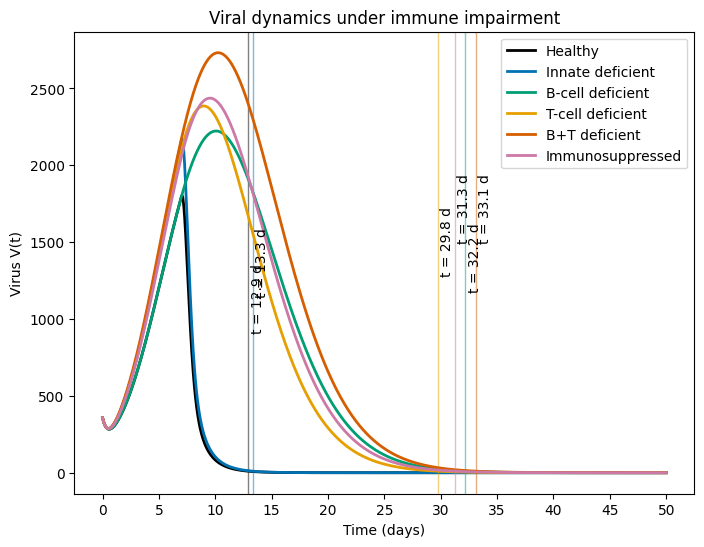

In [52]:
def simulate(params, y0):
    return solve_ivp(
        full_model, t_span, y0,
        args=(params,), t_eval=t_eval,
        method="BDF",
        rtol=1e-6, atol=1e-9,
    )

def viral_peak(sol):
    return np.max(sol.y[2])

def time_to_clearance(sol):
    if sol.t_events[0].size > 0:
        return sol.t_events[0][0]
    else:
        return np.nan

solutions = {
    "Healthy": simulate(params_healthy, y0_healthy),
    "Innate deficient": simulate(params_innate_def, y0_immune),
    "B-cell deficient": simulate(params_B_def, y0_B_def),
    "T-cell deficient": simulate(params_T_def, y0_immune),
    "B+T deficient": simulate(params_BT_def, y0_BT_def),
    "Immunosuppressed": simulate(params_drug_imm, y0_immune),
    #"Vaccinated": simulate(params_vaccine, y0_vaccine),
}

plt.figure(figsize=(8,6))
for label, sol in solutions.items():
    color = immune_color[label]
    plt.plot(sol.t, sol.y[2], color=color, lw=2, label=label)
    cleared, t_clear = compute_virus_clearance(
        sol.t, sol.y[2],
        min_duration=0.5
    )
    print('---',label,'---')
    print("Cleared:", cleared)
    print("Clearance time:", t_clear)
    if t_clear is not None:
        plt.axvline(
            t_clear,
            color=color,
            linestyle="-",
            linewidth=1,
            alpha=0.5,
        )
        plt.text(
            t_clear + 0.2,
            plt.ylim()[1] * 0.6,
            f"t = {t_clear:.1f} d",
            rotation=90,
            va="center",
            fontsize=10
        )
'''
plt.plot(sol_vaccine.t, sol_vaccine.y[2], color="#000000", ls="-.", label="Vaccinated")
if t_clear_vaccine is not None:
    plt.axvline(
        t_clear_vaccine,
        color="grey",
        linestyle="-.",
        linewidth=1,
        alpha=0.5,
    )
    plt.text(
        t_clear_vaccine + 0.2,
        plt.ylim()[1] * 0.6,
        f"t = {t_clear_vaccine:.1f} d",
        rotation=90,
        va="center",
        fontsize=10
    )
'''
plt.xticks(np.arange(0, 51, 5))
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.title("Viral dynamics under immune impairment")
plt.show()



## SUMMARY RESULTS

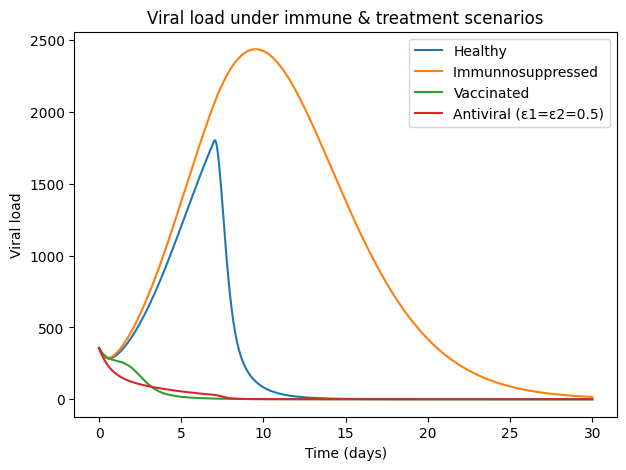

In [53]:
t_span = (0, 30)
t_eval = np.linspace(0, 30, 1500)

# baseline parameters + eps1, eps2
params_drug = params_full.copy() + [0.5, 0.5]   # combined treatment
sol_drug = solve_ivp(
    full_model_drug,
    t_span,
    y0_immune,
    args=(params_drug,),
    t_eval=t_eval,
    method="BDF",
    rtol=1e-6,
    atol=1e-9,
)

scenarios = {
    "Healthy": sol_immune,
    "Immunnosuppressed ": simulate(params_drug_imm, y0_immune),
    "Vaccinated": sol_vaccine,
    "Antiviral (ε1=ε2=0.5)": sol_drug,
    # Add others later:
    # "B-cell deficient": sol_B,
    # "T-cell deficient": sol_T,
    # "B+T deficient": simulate(params_BT_def, y0_BT_def),
    # "Immunosuppressed": sol_immunosupp
}


plt.figure(figsize=(7,5))

for name, sol in scenarios.items():
    plt.plot(t_eval, sol.y[2], label=name)

plt.xlabel("Time (days)")
plt.ylabel("Viral load")
plt.legend(loc= 'upper right')
plt.xticks(np.arange(0, 31, 5))
plt.title("Viral load under immune & treatment scenarios")
plt.show()


## From Viral Load to Offspring Distribution

ref:
    
     R. Ke, C. Zitzmann, D.D. Ho, R.M. Ribeiro, & A.S. Perelson, In vivo kinetics of SARS-CoV-2 infection and its relationship with a person’s infectiousness, Proc. Natl. Acad. Sci. U.S.A. 118 (49) e2111477118, https://doi.org/10.1073/pnas.2111477118 (2021). 

* Viral load as a proxy for infectiousness

    Experimental and modeling studies (Ke et al., PNAS, 2022) show that viral load (VL) is a strong surrogate for infectiousness. While total viral burden (AUC of VL) is sometimes used, the logarithm of viral load better correlates with transmission probability, especially at high VL values.

    Following this approach, the instantaneous infectiousness of an individual is modeled as:

    β(t)=β0log10(V(t)+1)

    where:
    V(t) is the within-host viral load,
    β0 is a scaling constant converting viral load into per-contact transmission probability.

    The total infectiousness of an individual over the course of infection is then approximated by: I=∫0->T β(t)dt

    which we estimate numerically from the simulated viral load trajectory.

In [54]:
def infectiousness(V, Vmin=1e2, beta0=1.0):
    return beta0 * np.maximum(0, np.log10(V / Vmin))
V = np.logspace(2, 10, 200)
I = infectiousness(V)


- Incorporating contact rates: settings and isolation

Transmission does not depend on viral load alone, but also on the number of contacts per unit time, which varies by setting.

We model this by assuming a constant average contact rate 
c, giving the expected number of secondary infections (assuming contacts with fully susceptible population):

R=c⋅I

While Rw governs viral invasion at the within-host level, the epidemiological reproduction number R0 emerges from the interaction between within-host viral dynamics and contact behavior.

Different social contexts correspond to different values of 
c:
| Setting / behavior | Interpretation         | Contact rate (c) (example) |
| ------------------ | ---------------------- | -------------------------- |
| Home isolation     | Strict quarantine      | 1–2 contacts/day           |
| General community  | Average adult          | 8–12 contacts/day          |
| School             | Children / adolescents | 15–25 contacts/day         |
| Hospital ward      | Healthcare workers     | 20–30 contacts/day         |

We use c=10 and estimated R0 in 

    Ke R, Romero-Severson E, Sanche S, Hengartner N. Estimating the reproductive number R0 of SARS-CoV-2 in the United States and eight European countries and implications for vaccination. J Theor Biol. 2021 May 21;517:110621. doi: 10.1016/j.jtbi.2021.110621. Epub 2021 Feb 13. PMID: 33587929; PMCID: PMC7880839.
for calibrating $\beta_0$

In [55]:
from numpy import trapezoid

def total_infectiousness(t, V, b=1):
    return trapezoid(infectiousness(V, beta0=b), t)
def expected_secondary_cases(t, V, c, b=1):
    return c * total_infectiousness(t, V, b)

c = 10  # contacts/day

I_healthy = total_infectiousness(sol_immune.t, sol_immune.y[2])
beta0 = 5 / (c * I_healthy)

print("Calibrated beta0 =", beta0)

Calibrated beta0 = 0.0642548948412627


In [56]:
social_contexts = {
    "Home isolation": 2,      # strict quarantine, 1–2 contacts/day
    "Community": 10,          # average adult
    "School": 20,             # children/adolescents
    "Hospital": 25             # healthcare workers
}


In [57]:

results = {}

for name, sol in scenarios.items():
    V = sol.y[2]
    t = sol.t
    
    AUClog = total_infectiousness(t, V, b=beta0)
    R = expected_secondary_cases(t, V, c, b=beta0)

    cleared, t_clear = compute_virus_clearance(
        sol.t, sol.y[2],
        V_clear=1.0,
        min_duration=0.5
    )

    
    results[name] = {
        "AUClog": AUClog,
        "R": R,
        "V_peak": np.max(V),
        "t_clear": t_clear,
        "P_transmission": 1-np.exp(-R)
    }

for name, res in results.items():
    t_clear_str = f"{res['t_clear']:.1f} d" if res['t_clear'] is not None else "not cleared"
    print(f"{name:20s} | "
          f"AUClog = {res['AUClog']:.2f} | "
          f"R = {res['R']:.2f} | "
          f"Peak VL = {res['V_peak']:.2e} | "
          f"Clearance = {t_clear_str} | "
          f"Prob transmission = {res['P_transmission']:.2f} ")


Healthy              | AUClog = 0.50 | R = 5.00 | Peak VL = 1.80e+03 | Clearance = 16.5 d | Prob transmission = 0.99 
Immunnosuppressed    | AUClog = 1.47 | R = 14.69 | Peak VL = 2.44e+03 | Clearance = not cleared | Prob transmission = 1.00 
Vaccinated           | AUClog = 0.05 | R = 0.46 | Peak VL = 3.57e+02 | Clearance = 6.6 d | Prob transmission = 0.37 
Antiviral (ε1=ε2=0.5) | AUClog = 0.04 | R = 0.37 | Peak VL = 3.57e+02 | Clearance = 9.2 d | Prob transmission = 0.31 


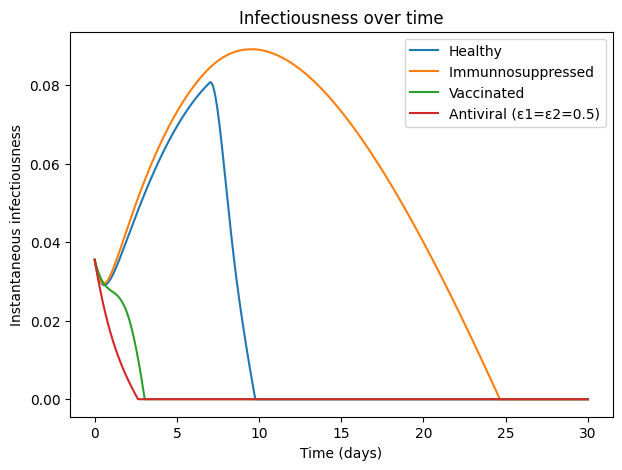

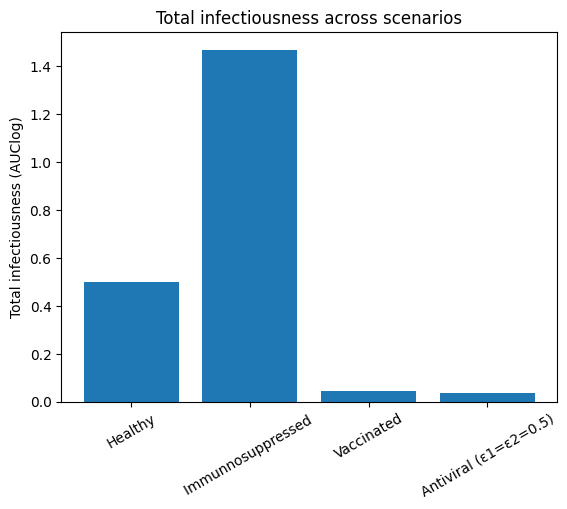

In [58]:
plt.figure(figsize=(7,5))

for name, sol in scenarios.items():
    I_t = infectiousness(sol.y[2], beta0=beta0)
    plt.plot(t_eval, I_t, label=name)

plt.xlabel("Time (days)")
plt.ylabel("Instantaneous infectiousness")
plt.legend(loc= 'upper right')
plt.title("Infectiousness over time")
plt.show()

names = list(results.keys())
AUClogs = [results[n]["AUClog"] for n in names]

plt.bar(names, AUClogs)
plt.ylabel("Total infectiousness (AUClog)")
plt.xticks(rotation=30)
plt.title("Total infectiousness across scenarios")
plt.show()



In [60]:
R_by_context = {}
P_by_context = {}
for scenario_name, sol in scenarios.items():
    V = sol.y[2]
    t = sol.t

    AUClog = total_infectiousness(t, V, b=beta0)
    R_by_context[scenario_name] = {"AUClog": AUClog}
    P_by_context[scenario_name] = {"AUClog": AUClog}

    for context_name, c in social_contexts.items():
        R_context = expected_secondary_cases(t, V, c, b=beta0)
        P_trans = 1 - np.exp(-R_context)

        R_by_context[scenario_name][context_name] = R_context
        P_by_context[scenario_name][context_name] = P_trans


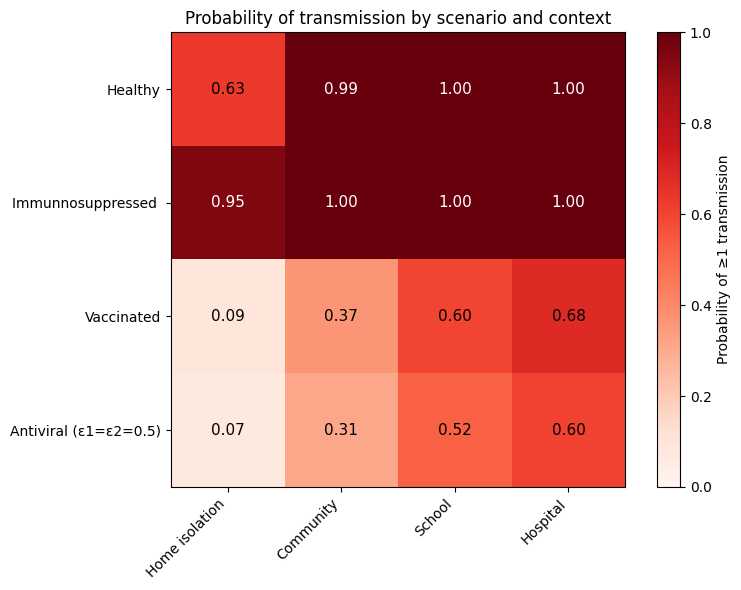

In [61]:
scenario_names = list(P_by_context.keys())
context_names = list(social_contexts.keys())

P_matrix = np.zeros((len(scenario_names), len(context_names)))

for i, sc in enumerate(scenario_names):
    for j, ctx in enumerate(context_names):
        P_matrix[i, j] = P_by_context[sc][ctx]
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(P_matrix, cmap="Reds", vmin=0, vmax=1)

# Axis labels
ax.set_xticks(np.arange(len(context_names)))
ax.set_yticks(np.arange(len(scenario_names)))
ax.set_xticklabels(context_names)
ax.set_yticklabels(scenario_names)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate cells
for i in range(len(scenario_names)):
    for j in range(len(context_names)):
        ax.text(
            j, i,
            f"{P_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="black" if P_matrix[i, j] < 0.7 else "white",
            fontsize=11
        )

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Probability of ≥1 transmission")

ax.set_title("Probability of transmission by scenario and context")

plt.tight_layout()
plt.show()


The heatmap shows the probability that an infected individual generates at least one secondary case across clinical scenarios and social contexts. Even when the expected number of secondary cases is below one, the probability of transmission remains non-negligible, highlighting the stochastic nature of transmission at the individual level.

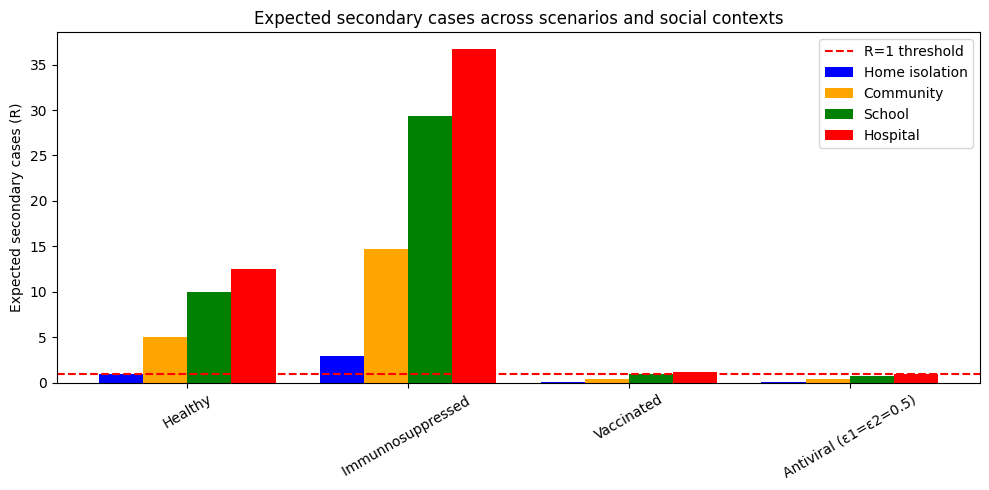

In [ ]:
contexts = list(social_contexts.keys())
scenarios_names = list(scenarios.keys())
n_scenarios = len(scenarios_names)
n_contexts = len(contexts)
colorsC=["blue", "orange", "green", "red"]

# Collect R values into a matrix
R_matrix = np.array([[R_by_context[sc][ctx] for ctx in contexts] for sc in scenarios_names])

# Bar plot setup
x = np.arange(n_scenarios)  # scenario positions
width = 0.2                 # width of each bar

plt.figure(figsize=(10,5))
for i, ctx in enumerate(contexts):
    plt.bar(x + i*width, R_matrix[:, i], width, color=colorsC[i], label=ctx)

plt.xticks(x + width*(n_contexts-1)/2, scenarios_names, rotation=30)
plt.ylabel("Expected secondary cases (R)")
plt.axhline(1, linestyle="--", color="red", label="R=1 threshold")
plt.title("Expected secondary cases across scenarios and social contexts")
plt.legend()
plt.tight_layout()
plt.show()


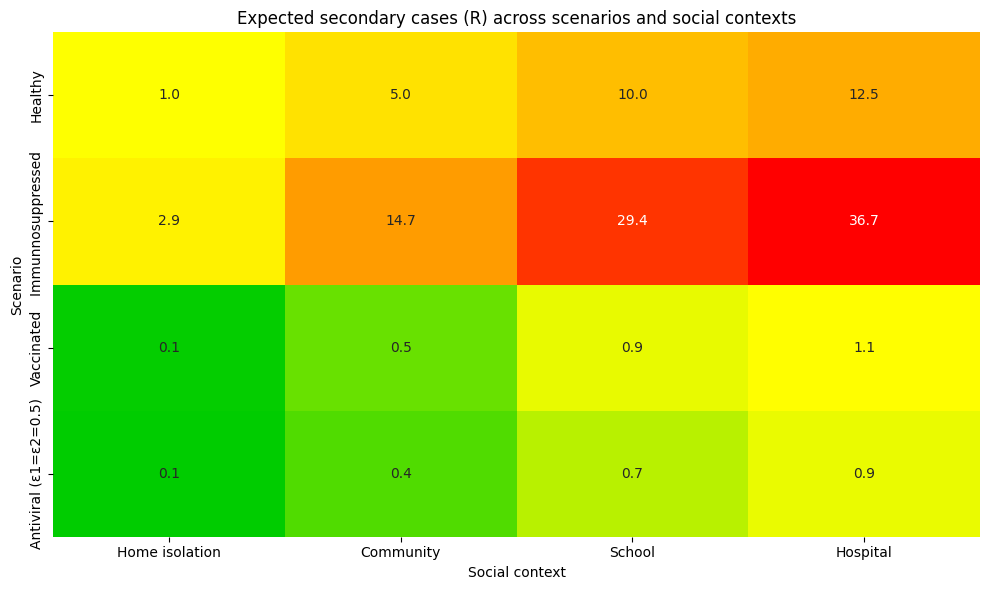

In [ ]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

# green for low R, red for high R, abrupt change at R=1
colorsR = [(0, 0.8, 0),  # green
          (1, 1, 0),    # yellow (optional for smooth transition)
          (1, 0, 0)]    # red
cmap = LinearSegmentedColormap.from_list("R_highlight", colorsR, N=256)

# --- Normalize around R=1 ---
norm = TwoSlopeNorm(vmin=R_matrix.min(), vcenter=1, vmax=R_matrix.max())

# --- Plot ---
plt.figure(figsize=(10,6))
ax=sns.heatmap(
    R_matrix, annot=True, fmt=".1f",
    xticklabels=contexts,
    yticklabels=scenarios_names,
    cmap=cmap,
    norm=norm,
    cbar=False
)
plt.title("Expected secondary cases (R) across scenarios and social contexts")
plt.ylabel("Scenario")
plt.xlabel("Social context")
plt.tight_layout()
plt.show()


- Offspring distribution: from mean to variability

    Actual transmission is stochastic. Even individuals with the same viral load trajectory will not infect exactly 
    R people. To account for this variability, we model the number of secondary cases 
    Z as a Poisson random variable:

    Z∼Poisson(R)

    This assumes:

    - homogeneous susceptibility among contacts,
    - independent transmission events.

    The Poisson distribution is appropriate for baseline scenarios, while extensions (e.g. negative binomial) could capture superspreading.

C:\Users\angel\AppData\Local\Temp\ipykernel_18752\4252364067.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.92])


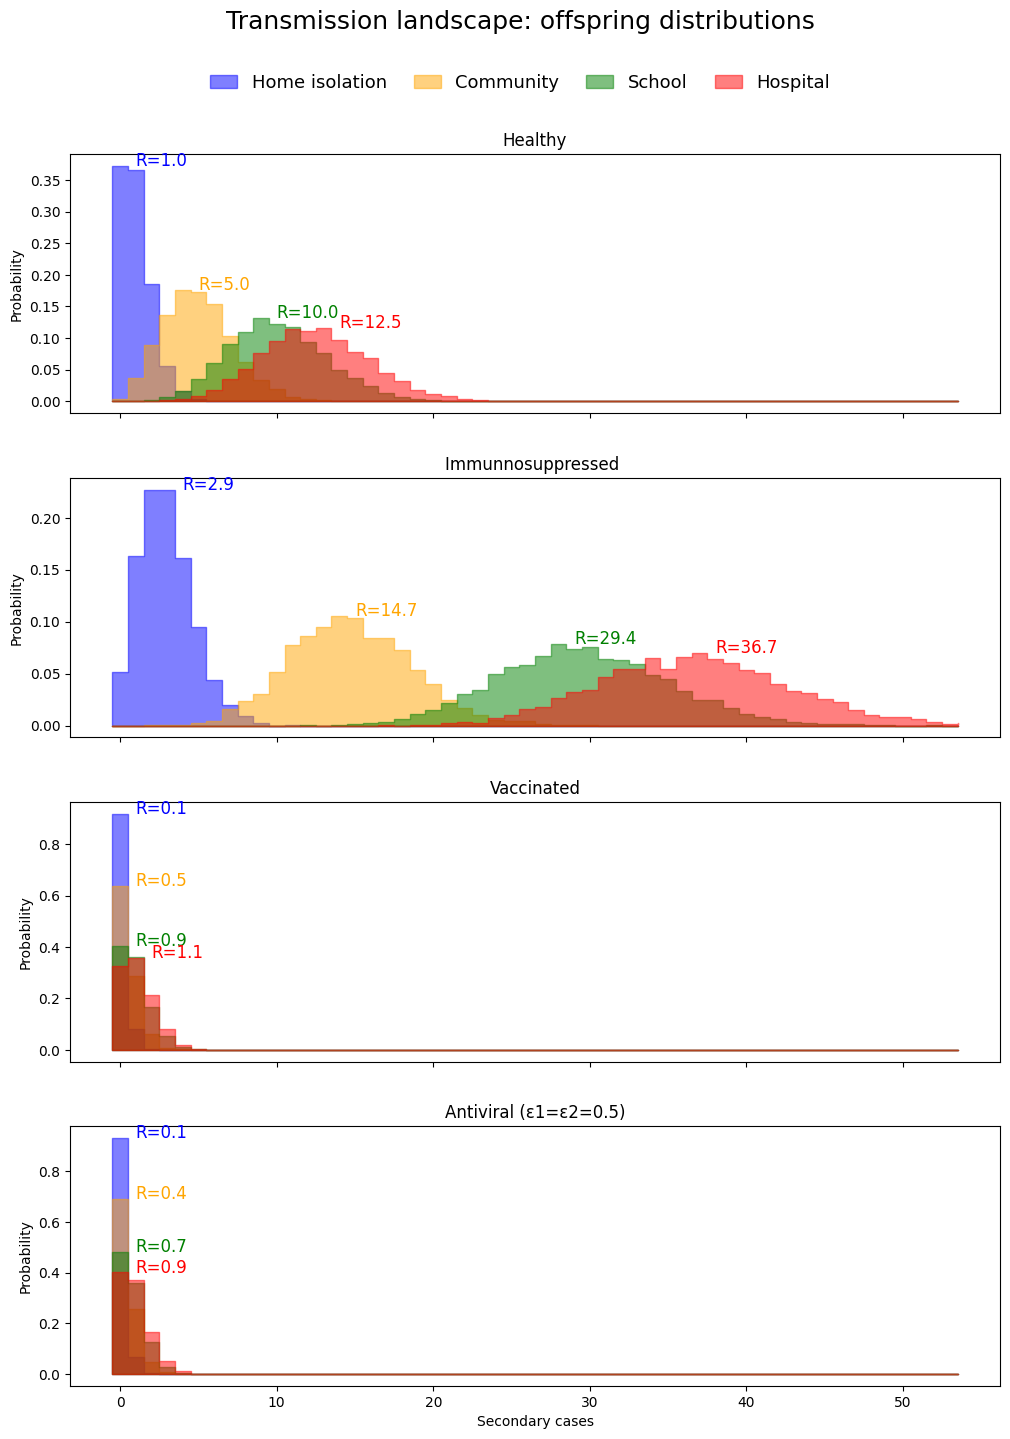

In [ ]:
n_samples = 5000

# Choose bins wide enough to cover all scenarios
max_R = np.max(R_matrix)
max_offspring = int(max_R + 3 * np.sqrt(max_R ))  # Poisson tail
bins = np.arange(0, max_offspring + 2) - 0.5

fig, axes = plt.subplots(
    len(scenarios_names), 1,
    figsize=(12, 16),   
    sharex=True,
    gridspec_kw={"hspace": 0.25}  
)

for i, (ax, sc) in enumerate(zip(axes, scenarios_names)):
    for j, ctx in enumerate(contexts):
        R_val = R_matrix[i, j]
        offspring = np.random.poisson(R_val, size=n_samples)
        hist, edges = np.histogram(offspring, bins=bins, density=True)

        ax.fill_between(
            edges[:-1], hist,
            step="post",
            alpha=0.5,
            color=colorsC[j],
            label=ctx if i == 0 else ""
        )

        peak_idx = np.argmax(hist)
        ax.text(
            edges[peak_idx]+1.5,
            hist[peak_idx] ,
            f"R={R_val:.1f}",
            fontsize=12,
            color=colorsC[j]
        )

    ax.set_ylabel("Probability")
    ax.set_title(sc)

axes[-1].set_xlabel("Secondary cases")

fig.suptitle(
    "Transmission landscape: offspring distributions",
    fontsize=18, y=0.97
)

fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.94),
    ncol=len(contexts),
    frameon=False,
    handlelength=1.5,
    columnspacing=1.5,
    fontsize=13
)
fig.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()


- Effect of immunity, vaccination, antivirals, and isolation

    Within this framework:

    Innate or adaptive immunodeficiency
    → higher and longer viral load
    → larger 
    I
    → heavier tail in offspring distribution

    Vaccination
    → shorter duration of high viral load
    → reduced 
    I even if early growth occurs

    Antiviral treatment
    → strong suppression of viral production
    → sharp reduction in 
    I

    Home isolation
    → reduction in 
    c, independent of immune status
    → can push 
    R<1 even for high viral loads

    Thus, public health interventions (isolation) and biomedical interventions (vaccines, antivirals) act on different components of transmission, but combine multiplicatively.

- Interpretation

    This modeling framework provides a clear multiscale link:

    Immune response→V(t)→I→R→offspring distribution

    It explains why:

    immunocompromised individuals may contribute disproportionately to transmission,

    antivirals are highly effective at reducing infectiousness,

    isolation remains crucial even when biomedical control is imperfect.